# Exploratory Data Analysis

In this notebook I am generating some corpus statistics and visualizations both within our Shakespearean plays and to show the differences between the TF-IDFs of our two target classes that were generated in the prior notebook. We are working with both vectors and the tokens that were generated in our training data set to create visualizations.

In [1]:
# importing libraries for plotting, tokenization, stopword removal
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE

import nltk
from nltk.collocations import *
from nltk import FreqDist
import string
import re

from gensim.models import word2vec
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import nltk
from nltk.corpus import stopwords

import random
np.random.seed(0)

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# importing data from first notebook
import pickle

with open('data/pickle_jar.pickle', 'rb') as f:
    pickle_jar = pickle.load(f)

X_train = pickle_jar[0]
X_test = pickle_jar[1]
y_train = pickle_jar[2]
y_test = pickle_jar[3]
X_train_50 = pickle_jar[4]
X_test_50 = pickle_jar[5]
X_train_ngrams = pickle_jar[6]
X_test_ngrams = pickle_jar[7]
train_lemmatized = pickle_jar[8]
test_lemmatized = pickle_jar[9]
train_tokens = pickle_jar[10]
test_tokens = pickle_jar[11]

## Play Lengths

As I am not working with a significant class imbalance in terms of the number of plays in each class, I also want to check to ensure that each body of plays is of comparable length. Keep in mind that this is the length of the plays not including stopwords.

In [3]:
# generating length of plays
shakespeare_lengths = []
for play in train_tokens[:30]:
    shakespeare_lengths.append(len(play))
non_shakespeare_lengths = []
for play in train_tokens[30:]:
    non_shakespeare_lengths.append(len(play))

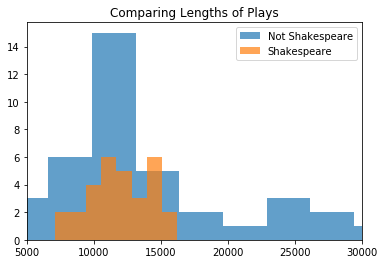

In [4]:
# plotting frequencies of play lengths
plt.hist(non_shakespeare_lengths, 15, alpha=.7, label='Not Shakespeare')
plt.hist(shakespeare_lengths, 8, alpha=.7, label='Shakespeare')
plt.xlim(5000, 30000)
plt.legend(loc='best')
plt.title('Comparing Lengths of Plays')
plt.show()

This is a reasonable distribution for each class. The bulk of plays in our training data fall between ~5000 and ~30000 words for each play (the wide window is to be expected, as comedies are much shorter than historical plays). There is a single play that falls above this as it is a compendium of all 6 of Robert Greene's plays.

## Most Common Features

Next I want to visualize the most common words between our two classes to see how separable certain words are in each. 

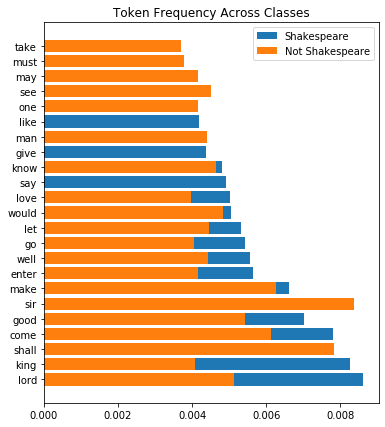

In [5]:
# generating FreqDist for each class
shakespeare_tokens = []
non_shakespeare_tokens = []
for play in train_tokens[:30]:
    shakespeare_tokens += play
for play in train_tokens[30:]:
    non_shakespeare_tokens += play
s_freqdist = FreqDist(shakespeare_tokens)
n_freqdist = FreqDist(non_shakespeare_tokens)

#counting all words in each class 
s_total_wordcount = sum(s_freqdist.values())
n_total_wordcount = sum(n_freqdist.values())

#pulling most common in each freqdist
s_top_20 = s_freqdist.most_common(20)
n_top_20 = n_freqdist.most_common(20)

#generating list of value/word foe each class with normalized frequency
s_x = []
s_y = []
for i, (word, value) in enumerate(s_top_20):
    normalized_frequency = value/s_total_wordcount
    s_x.append(word)
    s_y.append(normalized_frequency)
    
n_x = []
n_y = []
for i, (word, value) in enumerate(n_top_20):
    normalized_frequency = value/n_total_wordcount
    n_x.append(word)
    n_y.append(normalized_frequency)

# plotting most common words
plt.figure(figsize=(6, 7))
ax1 = plt.barh(s_x, s_y, label='Shakespeare')
ax2 = plt.barh(n_x, n_y, label='Not Shakespeare')
plt.legend((ax1[0], ax2[0]), ('Shakespeare', 'Not Shakespeare'))
plt.title('Token Frequency Across Classes')
plt.show;

## Visualizing TF-IDF Classes 

Let's visualize the TF-IDF for our 69 plays. The term frequency–inverse document frequency is a way of viewing a collection of documents, and shows the significance of each word in the corpus across our 69 plays. In order to visualize this in two dimensions, I am using Sklearn's t-distributed Stochastic Neighbor Embedding (TSNE) to reduce our tens of thousands of features. 

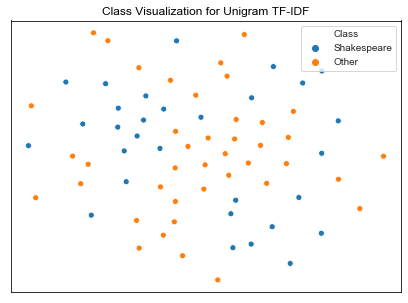

In [6]:
# transforming TF-IDF with TSNE
t_sne_object_2d = TSNE(n_components=2)
X_train_array = X_train.toarray()
transformed_data_2d = t_sne_object_2d.fit_transform(X_train_array)

# creating DataFrame for use with Seaborn
df = pd.DataFrame(transformed_data_2d, columns=['X_axis', 'Y_axis'])
df['Class'] = y_train
df.loc[df['Class'] == 1, 'Class'] = 'Shakespeare'
df.loc[df['Class'] == 0, 'Class'] = 'Other'

# generating Seaborn plot from full TF-IDF DataFrame
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
sns.set_style('whitegrid')
sns.scatterplot(x='X_axis', y='Y_axis', hue='Class', data=df)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.title('Class Visualization for Unigram TF-IDF')
plt.show()

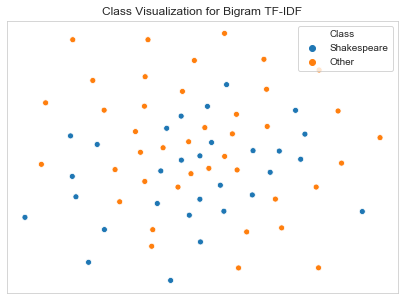

In [7]:
# transforming TF-IDF with TSNE from bigram/trigrams
t_sne_object_2d = TSNE(n_components=2)
X_train_ngrams_array = X_train_ngrams.toarray()
transformed_data_2d = t_sne_object_2d.fit_transform(X_train_ngrams_array)
transformed_data_2d.shape

# creating DataFrame for use with Seaborn
df = pd.DataFrame(transformed_data_2d, columns=['X_axis', 'Y_axis'])
df['Class'] = y_train
df.loc[df['Class'] == 1, 'Class'] = 'Shakespeare'
df.loc[df['Class'] == 0, 'Class'] = 'Other'

# generating Seaborn plot from full TF-IDF DataFrame
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
sns.set_style('whitegrid')
sns.scatterplot(x='X_axis', y='Y_axis', hue='Class', data=df)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.title('Class Visualization for Bigram TF-IDF')
plt.show()

There is certainly less separation between our two classes for the bigrams than there is for the unigrams, and it will be interesting to see whether that is reflected in our models' ability to use one dataset over the other.

## Word Vectors for T-SNE

Next, I am visualizing similarity between the most common words in our corpus. The Word2Vec model will generate a vector of 100 dimensions for each word, and identify similarity between these by moving a wide window of words across the text. We can then plot the similarity between these vectors in two dimensions.

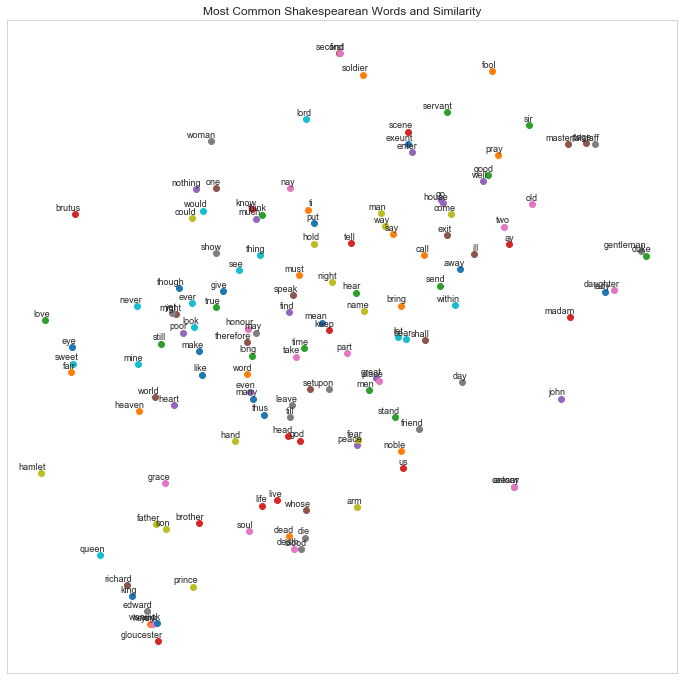

In [8]:
# creating function to plot word2vec model
def tsne_plot(model, plot_title):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50,
                      n_components=2,
                      init='pca',
                      n_iter=2500,
                      random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                    fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plt.title(plot_title)
    plt.show()

#plotting Shakespearean model
s_model = word2vec.Word2Vec(train_tokens[:30],
                            size=100,
                            window=20,
                            min_count=400,
                            workers=4)
tsne_plot(s_model, 'Most Common Shakespearean Words and Similarity')

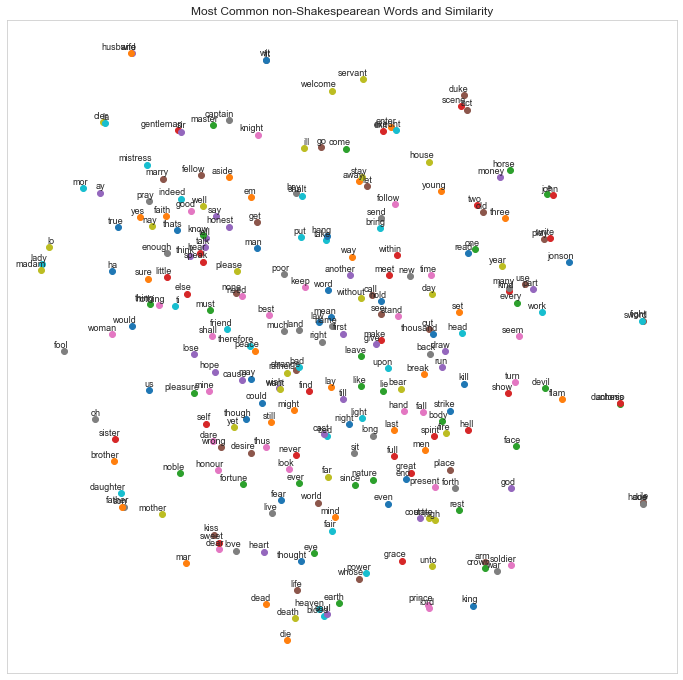

In [9]:
# plotting non-Shakespearean model
n_model = word2vec.Word2Vec(train_tokens[30:],
                            size=100,
                            window=20,
                            min_count=400,
                            workers=4)
tsne_plot(n_model, 'Most Common non-Shakespearean Words and Similarity')

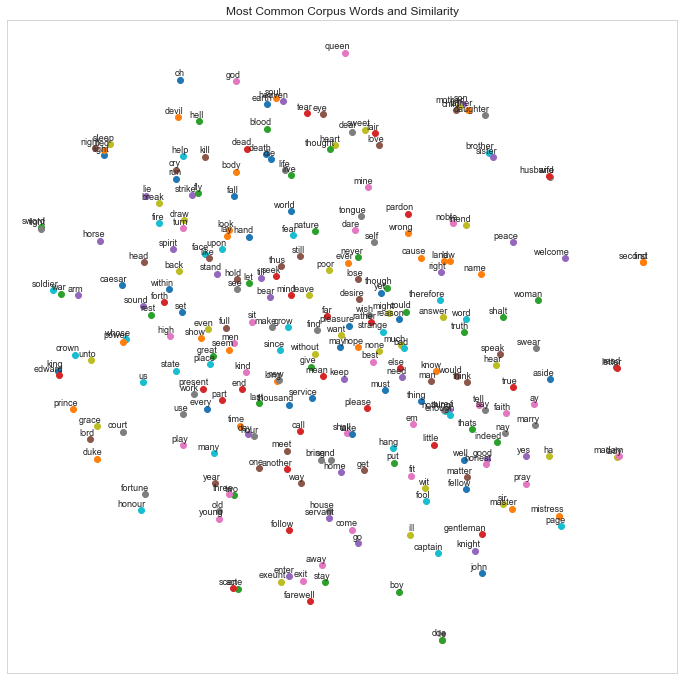

In [10]:
#plotting all corpus model
all_model = word2vec.Word2Vec(train_tokens,
                              size=50,
                              window=20,
                              min_count=600,
                              workers=4)
tsne_plot(all_model, 'Most Common Corpus Words and Similarity')

In [11]:
#showing similarities in our corpus to the word 'lord'
all_model.most_similar('lord')

[('grace', 0.6595050096511841),
 ('prince', 0.5939477682113647),
 ('king', 0.5509432554244995),
 ('court', 0.5210639238357544),
 ('edward', 0.5140853524208069),
 ('duke', 0.5133584141731262),
 ('unto', 0.5128682255744934),
 ('welcome', 0.47378963232040405),
 ('sit', 0.46106719970703125),
 ('noble', 0.44463443756103516)]

In [12]:
#showing similarities in our corpus to the word 'love'
all_model.most_similar('love')

[('fair', 0.7355344295501709),
 ('heart', 0.7185829877853394),
 ('sweet', 0.6911087036132812),
 ('thought', 0.684802770614624),
 ('desire', 0.6778296828269958),
 ('mine', 0.6577298045158386),
 ('dear', 0.6513521671295166),
 ('ever', 0.5918843746185303),
 ('self', 0.580817461013794),
 ('mind', 0.5770854949951172)]

This is a helpful technique for identifying word similarities in our text, and a way for us to identify themes in our text - we can see areas of life and death, courts and war, even love and family structure. 

## Word Clouds

Lastly, I wanted to see how Word Clouds give prominence to tokens in our text. 

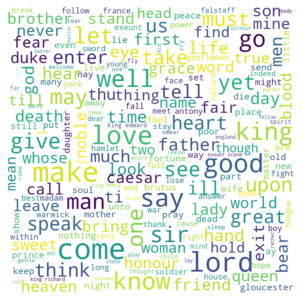

In [13]:
# creating BoW for Shakespeare plays for use in wordcloud
Shakespeare_BoW = []
for i in range(30):
    Shakespeare_BoW.append(' '.join(train_tokens[i]))

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800,
                      height=800,
                      max_font_size=80,
                      max_words=200,
                      background_color="white")\
                        .generate(' '.join(Shakespeare_BoW))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0) 
plt.show()

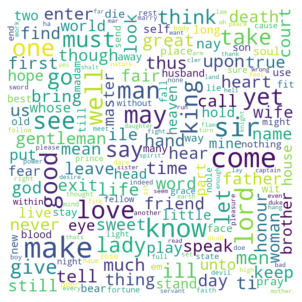

In [14]:
# creating BoW for non Shakespeare plays for use in wordcloud
not_Shakespeare_BoW = []
for i in range(30, 69):
    not_Shakespeare_BoW.append(' '.join(train_tokens[i]))
    
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800,
                      height=800,
                      max_font_size=80,
                      max_words=200,
                      background_color="white")\
                    .generate(' '.join(not_Shakespeare_BoW))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0) 
plt.show()

Neither of these word clouds is particularly enlightening of our text when we have the t-SNE and token bar charts to show our common words and their similarities. In the next notebook I will be moving on to the classification modeling of our texts.

## Chi-Square

Lastly, I want to visualize features using chi-squared, which measures dependence between stochastic variables, to show which variables are most relevant for classification. In order to plot this I will use both unigrams and bigrams.

In [24]:
# defining stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['art', 'doth', 'dost', 'ere', 'ere', 'hast', 'hath',
                   'hence', 'hither', 'nigh', 'oft', 'shouldst', 'thither',
                   'thee', 'thou', 'thine', 'thy', 'tis', 'twas', 'wast',
                   'whence', 'wherefore', 'whereto', 'withal', 'wouldst',
                   'ye', 'yon', 'yonder', 'th']
stopwords_list += list(string.punctuation)

# defining regex pattern
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# running TF-IDF Vectorizer again with unigrams and bigrams
tfidf = TfidfVectorizer(stop_words=stopwords_list,
                        token_pattern=pattern,
                        ngram_range=(1, 2))
X_train = tfidf.fit_transform(train_lemmatized)

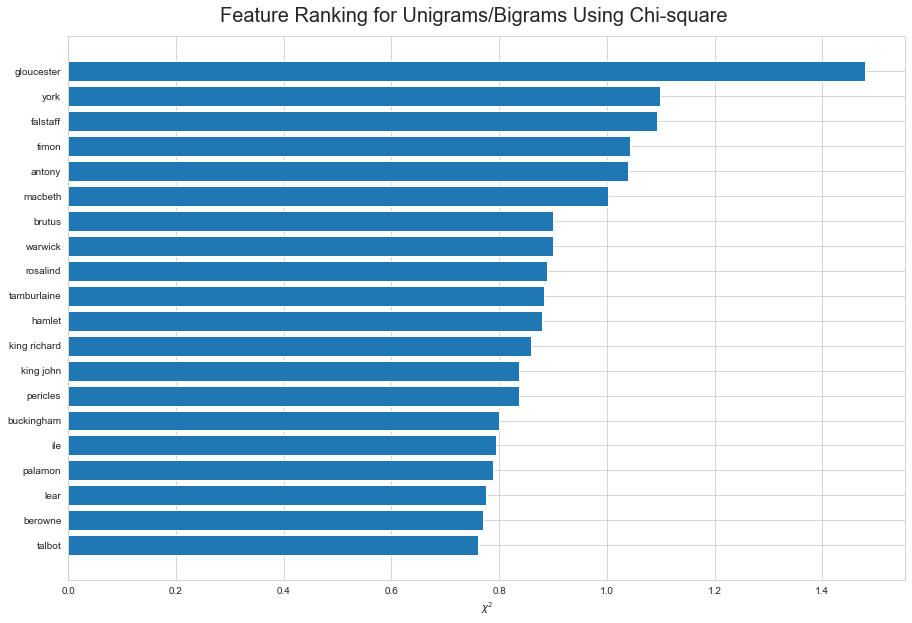

In [32]:
# creating plot
chi2score = chi2(X_train, y_train)[0]
plt.figure(figsize=(15,10))
wscores = list(zip(tfidf.get_feature_names(), chi2score))
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center')
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.figtext(.5,.9,'Feature Ranking for Unigrams/Bigrams Using Chi-square', fontsize=20, ha='center')
plt.show()

We are able to generate some enlightening visualizations to explore the vocabulary within our text through their co-occurences and frequency. Although character names are not common across the corpus, they occur frequently in our visualizations for associated nouns and adjectives.